# 0. Install required libraries

Uncomment the following cell and run it to install the required libraries. Make sure to start your virtual Python environment first (venv)

In [1]:
# %pip install -r requirements.txt

# 1. Setup
The first step is to import the necessary libraries and load the data and set the configuration.

In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam


2024-11-19 12:33:33.791256: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def load_images_from_folder(folder):
    files = [f for f in os.listdir(os.path.join(f'data', 'images', folder)) if os.path.isfile(os.path.join(f'data', 'images', folder, f))]
    return tf.data.Dataset.from_tensor_slices(files)

In [4]:
validation_data = load_images_from_folder('val')
training_data = load_images_from_folder('train')


In [5]:
train_length = len(training_data) # How many images are in the training set
validation_length = len(validation_data) # How many images are in the validation set
print(f'train_length: {train_length}')
batch_size = 8 # How many images are in one batch (the model will be trained on this many images at once), higher values will make the training faster but less stable and more memory-intensive
learning_rate = 0.001 # How fast the model learns, higher values will make the model learn faster but might make it less stable. We will use a LearningRateScheduler to decrease the learning rate over time
learning_rate_decay = 0.9 # How much the learning rate will be decreased after each epoch
learning_rate_decay_steps = 10 # How many epochs will be done before the learning rate is decreased
buffer_size = 30000 # How many images are stored in memory, higher values will make the training faster but more memory-intensive
steps_per_epoch = train_length // batch_size # How many batches are in one epoch
image_size = (96, 96) # The size of the images the model will be trained on, higher values will make the model more accurate but will require more data, memory and time
seed = 420 # The seed for the random number generator, this will make the training reproducible
epochs = 64 # How many times the model will see the whole dataset, we stop the training early if the model stops improving
model_version = 'v0_5' # The version of the model, this will be used to save the model


train_length: 13386


- v0_1: initial training, verify the model [:-20] not trained, (256, 256), bz 8
- v0_2: allowed all layers to be trained, (400, 400), 8
- v0_3: allowed all layers to be trained, (224, 224), 8, but only single output
 loss: 0.4999 - mse: 0.0267 - val_loss: 0.5272 - val_mse: 0.0305 - lr: 5.9605e-11
- v0_4: small model (96, 96), learning decay 0.9, 10 loss: 0.6089 - mse: 0.0411 - val_loss: 0.6408 - val_mse: 0.0459 - lr: 7.9766e-05
- v0_5: small model (96, 96), learning decay 0.9, 10 loss: 0.7


### 1.1. Create dataset using labels

In [6]:
def parse_label_line(line):
    parts = tf.strings.split(line)
    # Filter out empty lines
    if tf.equal(tf.size(parts), 0):
        return tf.constant([0.0, 0.0, 0.0, 0.0])

    parts = tf.strings.to_number(parts, out_type=tf.float32)
    # class_id = parts[0]
    center_x = parts[1]
    center_y = parts[2]
    width = parts[3]
    height = parts[4]

    # Convert (center_x, center_y, width, height) to (x_min, y_min, x_max, y_max)
    x_min = center_x - (width / 2.0)
    y_min = center_y - (height / 2.0)
    x_max = center_x + (width / 2.0)
    y_max = center_y + (height / 2.0)

    # Return bounding box tensor and class ID separately
    return tf.stack([x_min, y_min, x_max, y_max])

def compute_area(bbox):
    width = bbox[2] - bbox[0]
    height = bbox[3] - bbox[1]
    return width * height

def parse_image_and_label(image_path, label_path):
    # Read and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)  # Adjust based on your model's input size
    image = tf.cast(image, tf.float32) / 255.0

    # Read the label file
    label_file_content = tf.io.read_file(label_path)
    label_lines = tf.strings.split(label_file_content, '\n')

    # Map each label line to bounding box coordinates
    bbox_labels = tf.map_fn(parse_label_line, label_lines, dtype=tf.float32)

    areas = tf.map_fn(compute_area, bbox_labels)
    largest_box_idx = tf.argmax(areas)
    largest_box = bbox_labels[largest_box_idx]

    return image, largest_box

def create_dataset(data_dir):
    image_dir = os.path.join('data', 'images', data_dir)
    label_dir = os.path.join('data', 'labels', data_dir)

    image_file_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    label_file_paths = sorted([os.path.join(label_dir, fname[:-4] + '.txt') for fname in os.listdir(image_dir)])

    dataset = tf.data.Dataset.from_tensor_slices((image_file_paths, label_file_paths))
    return dataset.map(parse_image_and_label)

# Create the datasets
train_images = create_dataset('train')
test_images = create_dataset('val')

Instructions for updating:
Use fn_output_signature instead


In [7]:
train_batches = (
    train_images
    .cache()
    .shuffle(buffer_size, seed=seed)
    .batch(batch_size)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(batch_size)


### 1.2. Validate data and labels are loaded correctly

In [8]:

def display(image, bbox, prediction=None):
    plt.figure(figsize=(5, 5))

    # Convert the image to displayable format
    img = tf.keras.utils.array_to_img(image)
    plt.imshow(img)
    plt.axis('off')

    ax = plt.gca()  # Get current axis

    x_min, y_min, x_max, y_max = bbox[:4]
    # Calculate width and height
    width = x_max - x_min
    height = y_max - y_min
    # Create a rectangle patch
    rect = patches.Rectangle((x_min * img.width, y_min * img.height), 
                                width * img.width, 
                                height * img.height, 
                                linewidth=2, 
                                edgecolor='r', 
                                facecolor='none')
    ax.add_patch(rect)
    if prediction is not None:
        x_min, y_min, x_max, y_max = prediction[0][:4]
        # Calculate width and height
        width = x_max - x_min
        height = y_max - y_min
        # Create a rectangle patch
        rect = patches.Rectangle((x_min * img.width, y_min * img.height), 
                                width * img.width, 
                                height * img.height, 
                                linewidth=2, 
                                edgecolor='b', 
                                facecolor='none')
        ax.add_patch(rect)
    plt.show()


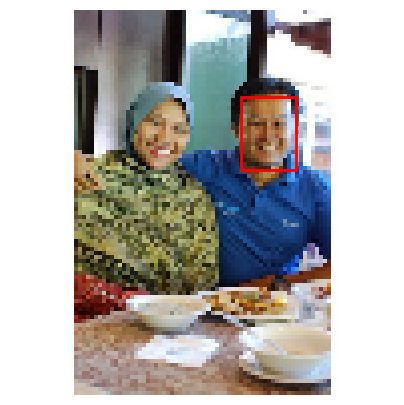

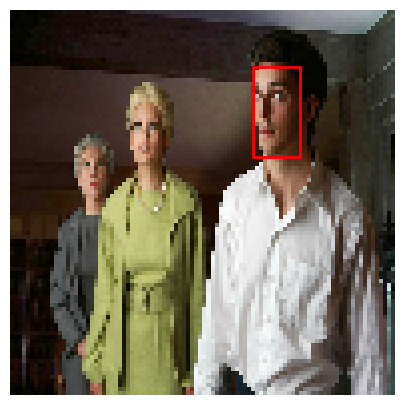

In [9]:
for image, labels in train_images.take(2):
  sample_image, sample_labels = image, labels
  display(image, labels)

# 2. Create a model

In [10]:
def create_object_detection_model(input_shape=(image_size[0], image_size[1], 3)):
    # Define the input
    input_image = layers.Input(shape=input_shape)

    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')

    # Freeze part of the base model to retain pre-trained weights
    base_model.trainable = True
    # Freeze all layers except the top few layers
    # for layer in base_model.layers[:-20]:  # Adjust this number as needed
    #     layer.trainable = False

    x = base_model(input_image)

    # Add global average pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    bbox_output = layers.Dense(4, activation='softmax')(x)

    # Create the model
    model = models.Model(inputs=input_image, outputs=[bbox_output])

    return model


### 2.1. Create a loss function and compile the model

In [11]:
@tf.keras.saving.register_keras_serializable()
def iou_loss(y_true, y_pred):
    # Calculate the intersection
    x_min_inter = tf.maximum(y_true[..., 0], y_pred[..., 0])
    y_min_inter = tf.maximum(y_true[..., 1], y_pred[..., 1])
    x_max_inter = tf.minimum(y_true[..., 2], y_pred[..., 2])
    y_max_inter = tf.minimum(y_true[..., 3], y_pred[..., 3])

    intersection = tf.maximum(x_max_inter - x_min_inter, 0) * tf.maximum(y_max_inter - y_min_inter, 0)

    # Calculate the union
    true_area = (y_true[..., 2] - y_true[..., 0]) * (y_true[..., 3] - y_true[..., 1])
    pred_area = (y_pred[..., 2] - y_pred[..., 0]) * (y_pred[..., 3] - y_pred[..., 1])

    union = true_area + pred_area - intersection

    # Calculate IoU
    iou = intersection / tf.maximum(union, 1e-6)

    # IoU loss (you want to maximize IoU, hence minimizing its inverse)
    return 1 - iou


In [12]:
model = create_object_detection_model()

optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss=iou_loss,
              metrics='mse')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 2263108 (8.63 MB)
Trainable params: 2228996 (8.50 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


### 2.2. Check predictions are working correctly

In [13]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, bboxes in dataset.take(num):
            predictions = model.predict(image)  # Predict bounding boxes
            display(image, bboxes, predictions)  # Visualize image with predicted bboxes
    else:
        predictions = model.predict(sample_image[tf.newaxis, ...])  # Predict bounding boxes on a sample image
        display(sample_image, sample_labels, predictions)  # Visualize sample image with predicted bboxes


1/1 [==============================] - 1s 741ms/step


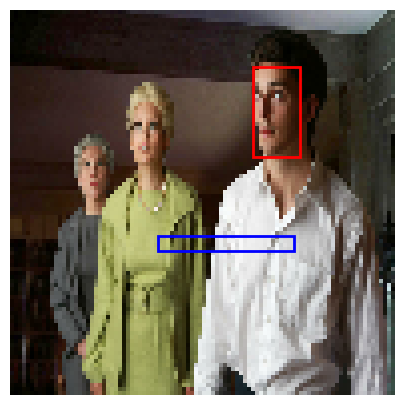

In [14]:
show_predictions()


In [15]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


# 3. Train the model

In [16]:
def lr_schedule(epoch, lr):
    if epoch > learning_rate_decay_steps:
        return lr * learning_rate_decay 
    return lr

1/1 [==============================] - 0s 26ms/step


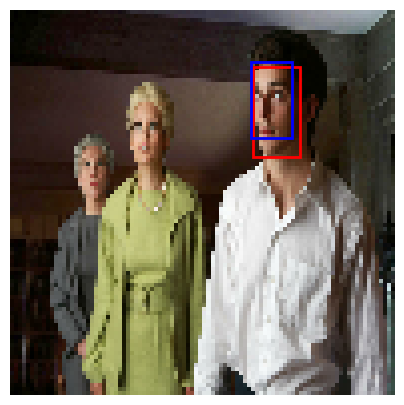


Sample Prediction after epoch 62

1673/1673 [==============================] - 321s 192ms/step - loss: 0.7079 - mse: 0.0368 - val_loss: 0.7140 - val_mse: 0.0393 - lr: 4.6384e-06


In [17]:
validation_subsplits = 3
validation_steps = validation_length//batch_size//validation_subsplits

lr_scheduler = LearningRateScheduler(lr_schedule)

checkpoint = ModelCheckpoint(filepath=f'best_model_{model_version}.h5',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_history = model.fit(train_batches, epochs=epochs,
                          steps_per_epoch=steps_per_epoch,
                          validation_steps=validation_steps,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback(), lr_scheduler, checkpoint, early_stopping])


# 4. Evaluate history (check for overfitting etc)

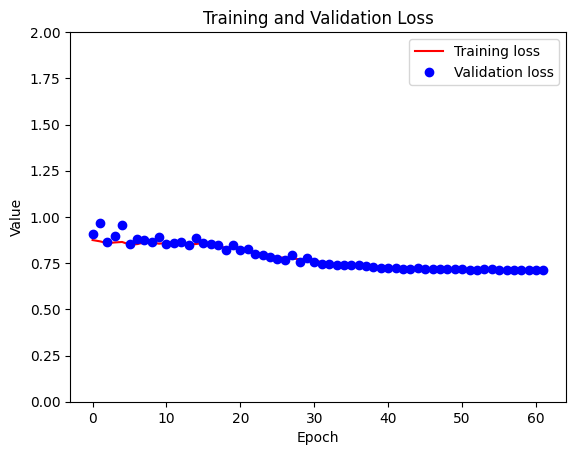

In [18]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
# accuracy = model_history.history['accuracy']
# val_accuracy = model_history.history['val_accuracy']

if len(val_loss) < len(loss):
    val_loss += [val_loss[-1]] * (len(loss) - len(val_loss))
# if len(val_accuracy) < len(accuracy):
#     val_accuracy += [val_accuracy[-1]] * (len(accuracy) - len(val_accuracy))

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
# plt.plot(model_history.epoch, accuracy, 'r--', label='Training accuracy')
# plt.plot(model_history.epoch, val_accuracy, 'bs', label='Validation accuracy')
plt.title('Training and Validation Loss')
# plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim([0, 2])
plt.legend()
plt.show()


# 5. Manually evaluate the model on the test set

1/1 [==============================] - 0s 28ms/step


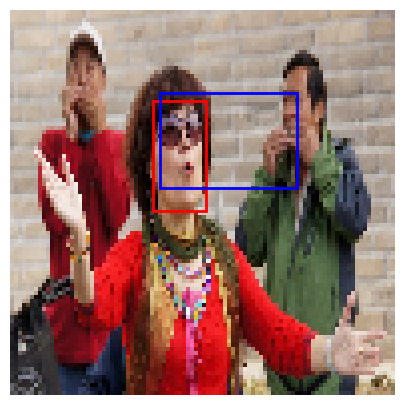

1/1 [==============================] - 0s 28ms/step


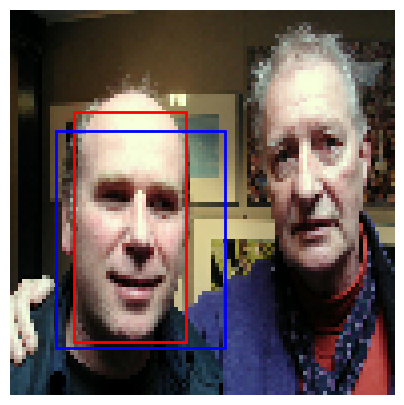

1/1 [==============================] - 0s 30ms/step


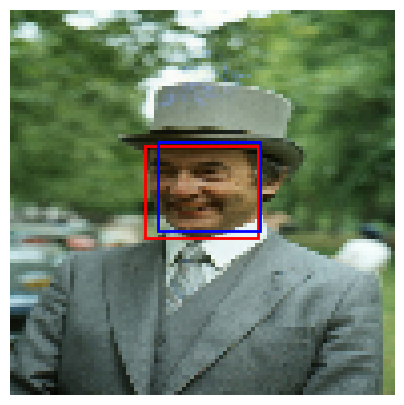

1/1 [==============================] - 0s 32ms/step


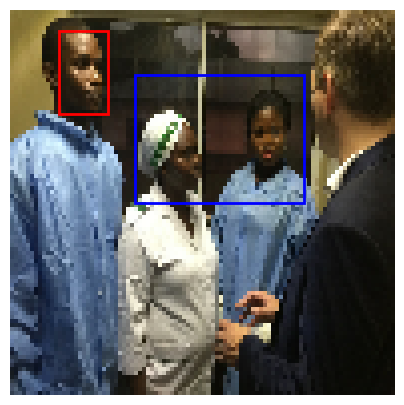

1/1 [==============================] - 0s 29ms/step


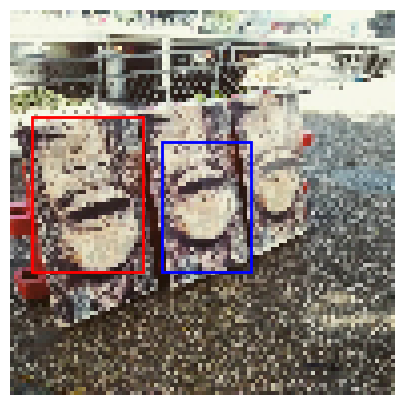

In [19]:
for image, labels in test_images.take(5):
  sample_image, sample_labels = image, labels
  show_predictions()

# 6. Save the model

In [20]:
model.save(f'models/{model_version}.keras')


In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with tf.io.gfile.GFile(f'models/{model_version}.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/h8/1yqbh1px66l_htqzsttx62x80000gn/T/tmpo1pu0gi2/assets


INFO:tensorflow:Assets written to: /var/folders/h8/1yqbh1px66l_htqzsttx62x80000gn/T/tmpo1pu0gi2/assets
2024-11-01 03:52:36.677466: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-11-01 03:52:36.677483: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-11-01 03:52:36.678134: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/h8/1yqbh1px66l_htqzsttx62x80000gn/T/tmpo1pu0gi2
2024-11-01 03:52:36.714120: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-11-01 03:52:36.714136: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/h8/1yqbh1px66l_htqzsttx62x80000gn/T/tmpo1pu0gi2
2024-11-01 03:52:36.783244: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-11-01 03:52:36.821141: I tensorflow/cc/saved_model/load